# Ejercicio 2 — Comparación de clasificadores: Naive Bayes vs KNN / Árbol de Decisión

En este cuaderno comparamos el rendimiento de un clasificador Naive Bayes (GaussianNB) con dos alternativas: K-Nearest Neighbors (KNN) y un Árbol de Decisión (Decision Tree), usando el mismo conjunto de datos. Para mayor reproducibilidad usaremos el dataset `breast_cancer` provisto por `sklearn.datasets` (problema binario).

Pasos:
- Cargar datos y explorar brevemente.
- Preparar pipelines (escalado cuando aplique).
- Evaluar mediante validación cruzada (accuracy, precision, recall, f1, ROC AUC).
- Entrenar en un split y mostrar matriz de confusión y classification report.
- Visualizar curvas ROC y concluir.

In [1]:
# Imports y carga de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay)
sns.set(style='whitegrid')

# Cargar dataset
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
df = pd.concat([X, y.rename('target')], axis=1)
print(df.shape)
df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [2]:
# Exploración rápida
print('Clases:', np.unique(y), 'Counts:', np.bincount(y))
print('\nDescripción rápida de las variables:')
df.describe().T[['mean','std','min','max']].head()

Clases: [0 1] Counts: [212 357]

Descripción rápida de las variables:


,mean,std,min,max
mean radius,14.127292,3.524049,6.98100,28.1100
mean texture,19.289649,4.301036,9.71000,39.2800
mean perimeter,91.969033,24.298981,43.79000,188.5000
mean area,654.889104,351.914129,143.50000,2501.0000
mean smoothness,0.096360,0.014064,0.05263,0.1634


In [4]:
# Preparar modelos y pipelines
models = {
    'GaussianNB': Pipeline([('nb', GaussianNB())]),
    'KNN (k=5)': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))]),
    'DecisionTree': Pipeline([('dt', DecisionTreeClassifier(random_state=0))])
}

# Parámetros de CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scoring = ['accuracy','precision','recall','f1','roc_auc']

# Evaluación por validación cruzada (5-fold)
cv_results = {}
for name, pipe in models.items():
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
    # resumimos media y std
    summary = {metric: (res[f'test_{metric}'].mean(), res[f'test_{metric}'].std()) for metric in scoring}
    cv_results[name] = summary

pd.DataFrame({k: {m: f"{v[0]:.3f} ± {v[1]:.3f}" for m,v in vals.items()} for k,vals in cv_results.items()}).T

,accuracy,precision,recall,f1,roc_auc
GaussianNB,0.939 ± 0.020,0.937 ± 0.034,0.969 ± 0.016,0.952 ± 0.015,0.989 ± 0.006
KNN (k=5),0.965 ± 0.021,0.955 ± 0.029,0.992 ± 0.011,0.973 ± 0.016,0.981 ± 0.009
DecisionTree,0.926 ± 0.022,0.942 ± 0.021,0.941 ± 0.029,0.941 ± 0.018,0.921 ± 0.022



GaussianNB
              precision    recall  f1-score   support

           0      0.889     0.906     0.897        53
           1      0.944     0.933     0.939        90

    accuracy                          0.923       143
   macro avg      0.916     0.919     0.918       143
weighted avg      0.923     0.923     0.923       143



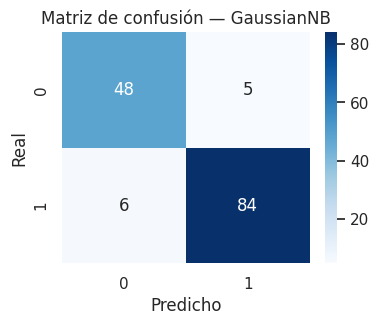


KNN (k=5)
              precision    recall  f1-score   support

           0      0.979     0.887     0.931        53
           1      0.937     0.989     0.962        90

    accuracy                          0.951       143
   macro avg      0.958     0.938     0.946       143
weighted avg      0.953     0.951     0.950       143



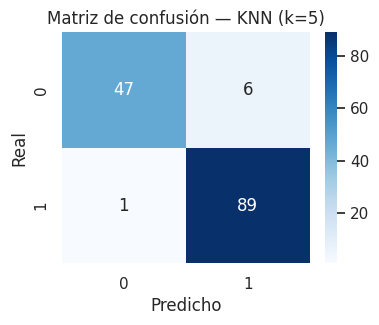


DecisionTree
              precision    recall  f1-score   support

           0      0.842     0.906     0.873        53
           1      0.942     0.900     0.920        90

    accuracy                          0.902       143
   macro avg      0.892     0.903     0.897       143
weighted avg      0.905     0.902     0.903       143



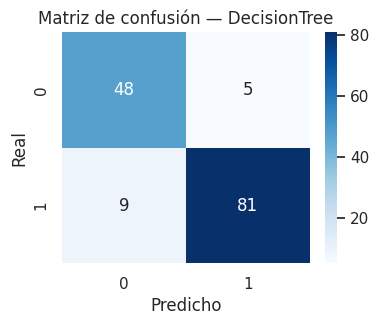

In [5]:
# División train/test para informes y visualizaciones finales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps[list(pipe.named_steps.keys())[-1]], 'predict_proba') else None
    fitted[name] = {'estimator': pipe, 'y_pred': y_pred, 'y_prob': y_prob}
    print('\n' + '='*40)
    print(name)
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusión — {name}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

<Figure size 700x600 with 0 Axes>

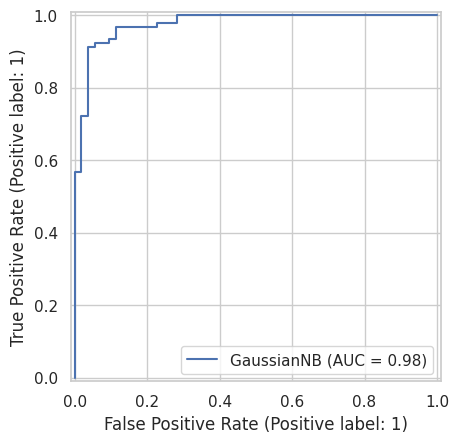

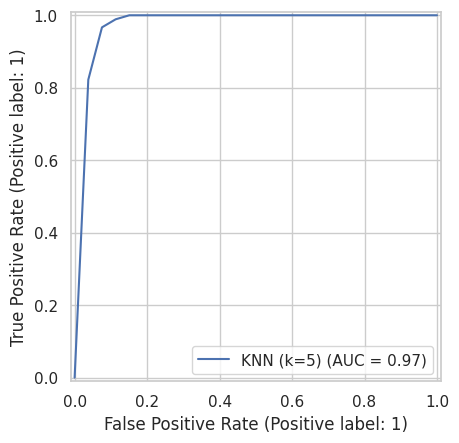

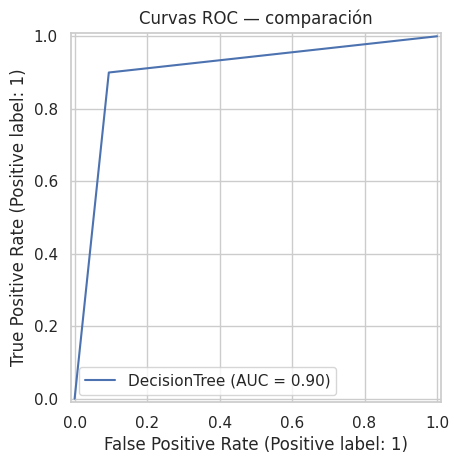

In [6]:
# Curvas ROC comparadas (solo para modelos que devuelven probabilidades)
plt.figure(figsize=(7,6))
for name, info in fitted.items():
    if info['y_prob'] is not None:
        RocCurveDisplay.from_predictions(y_test, info['y_prob'], name=name)
plt.title('Curvas ROC — comparación')
plt.legend()
plt.show()

In [7]:
# Resumen comparativo final (valores por CV ya calculados)
df_cmp = pd.DataFrame({k: {metric: cv_results[k][metric][0] for metric in cv_results[k].keys()} for k in cv_results.keys()}).T
df_cmp = df_cmp.rename(columns={'accuracy':'Accuracy','precision':'Precision','recall':'Recall','f1':'F1','roc_auc':'ROC_AUC'})
df_cmp.style.format('{:.3f}')

,Accuracy,Precision,Recall,F1,ROC_AUC
GaussianNB,0.939,0.937,0.969,0.952,0.989
KNN (k=5),0.965,0.955,0.992,0.973,0.981
DecisionTree,0.926,0.942,0.941,0.941,0.921


## Conclusiones

- Presentamos métricas (accuracy, precision, recall, F1 y ROC AUC) usando validación cruzada 5-fold para comparar los modelos.
- Observa que KNN y Decision Tree pueden necesitar ajuste de hiperparámetros para alcanzar su máximo desempeño; GaussianNB es muy rápido y a menudo competitivo en datos con características aproximadamente gaussianas.
- Para una comparación más formal se podrían aplicar pruebas estadísticas emparejadas o realizar búsqueda de hiperparámetros (GridSearchCV) y luego comparar sobre un test hold-out.

